In [ ]:
################################################################################
#                                                                              #
#                         PROJECT EVO - VERSION 1.0                            #
#                           ProjectEvo_V1.ipynb                                #
#                                                                              #
################################################################################

# --- 1. CONFIGURACIÓN DEL ENTORNO Y LIBRERÍAS ---
# Instalación silenciosa de dependencias críticas
!pip install pygad -q
!pip install spacy -q
!python -m spacy download es_core_news_sm -q

import pandas as pd
import numpy as np
import re
import spacy
import pygad
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Importaciones de Scikit-Learn y NLP
from google.colab import drive
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

# Configuración visual y de sistema
# warnings.filterwarnings('ignore')
# sns.set_style("whitegrid")

# Configuración de Hardware (GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"--- ESTADO DEL SISTEMA ---")
print(f"Dispositivo de Aceleración: {device}")
if torch.cuda.is_available():
    print(f"GPU Detectada: {torch.cuda.get_device_name(0)}")
    spacy.require_gpu()
    print("✅ GPU activada para procesamiento NLP y Redes Neuronales.")
else:
    print("⚠️ ADVERTENCIA: GPU no detectada. El entrenamiento será lento.")

# Carga del modelo de lenguaje
nlp = spacy.load("es_core_news_sm", disable=["ner", "parser"])
print("✅ Librerías y Modelos cargados correctamente.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.6/89.6 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 24.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
--- ESTADO DEL SISTEMA ---
Dispositivo de Aceleración: cuda
GPU Detectada: Tesla T4
✅ GPU activada para procesamiento NLP y Redes Neuronales.
✅ Librerías y Modelos cargados correctamente.


In [ ]:
# URL del archivo en formato Raw
ruta_github = 'https://raw.githubusercontent.com/berniehans/DataCallao/main/v2_dataset_callao.csv'

try:
    # Cargamos el archivo directamente desde la URL de GitHub
    df = pd.read_csv(ruta_github, sep=';', encoding='latin1')
    print(f"Dataset cargado exitosamente desde GitHub: {len(df)} registros.")
except Exception as e:
    print(f"Error al cargar desde GitHub: {e}")

# Muestreo estratégico para optimizar tiempos (Sampling)
# Mantenemos un tamaño representativo pero manejable
df_sampled = df.groupby('TIPOLOGIA').head(100_000).reset_index(drop=True)

# Definición de Variables
X_raw = df_sampled['DESCRIPCION_OCURRENCIA'].astype(str)
y_raw = df_sampled['TIPOLOGIA']

# Codificación de Etiquetas (Target Encoding)
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y_raw)
clases = encoder.classes_
print(f"Clases a predecir ({len(clases)}): {clases}")

# --- CÁLCULO DE PESOS PARA BALANCEO ---
# Esto es crucial para mejorar el F1-Score en clases minoritarias
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_encoded), y=y_encoded)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
print(f"Pesos de clases calculados para corregir desbalanceo.")

Dataset cargado exitosamente desde GitHub: 98458 registros.
Clases a predecir (8): ['AMBIENTALES ' 'APOYO AL CIUDADANO ' 'FISCALIZACION Y DEFENSA CIVIL '
 'FISICA ' 'FISICA(SALUD) ' 'PROTECCION FAMILIAR ' 'SEGURIDAD '
 'TRANSITO Y SEGURIDAD VIAL ']
Pesos de clases calculados para corregir desbalanceo.


--- REPORTE ESTADÍSTICO INICIAL ---


/tmp/ipython-input-1602142406.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y=y_raw, order=y_raw.value_counts().index, palette="viridis")


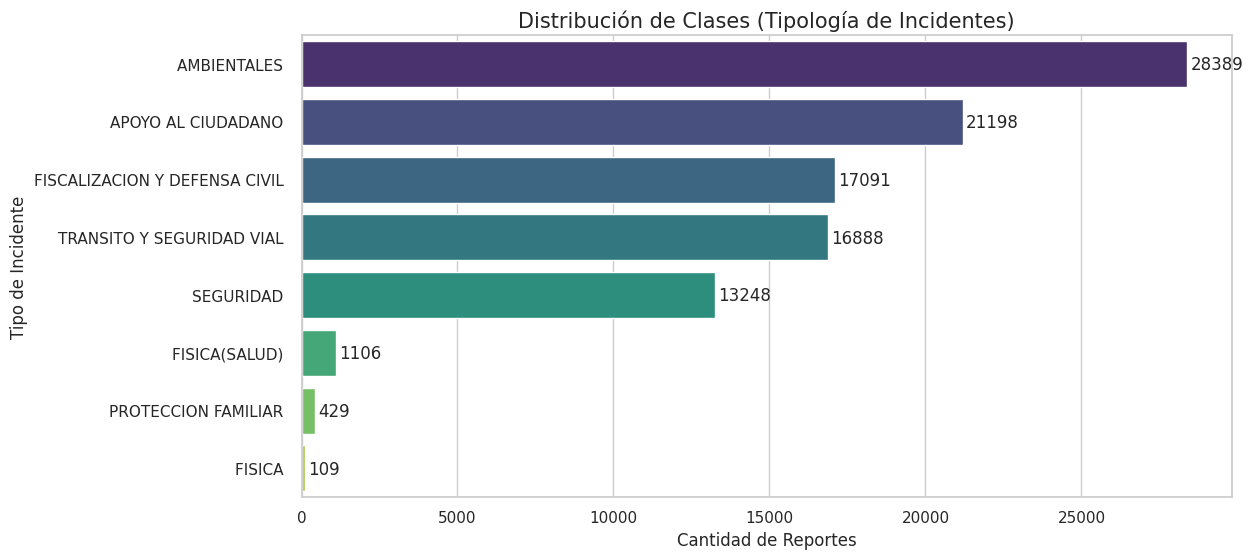


OBSERVACIÓN: Note la diferencia drástica entre la clase mayoritaria y la minoritaria.
Esto justifica el uso de F1-Score Macro y pesos balanceados en el modelo.



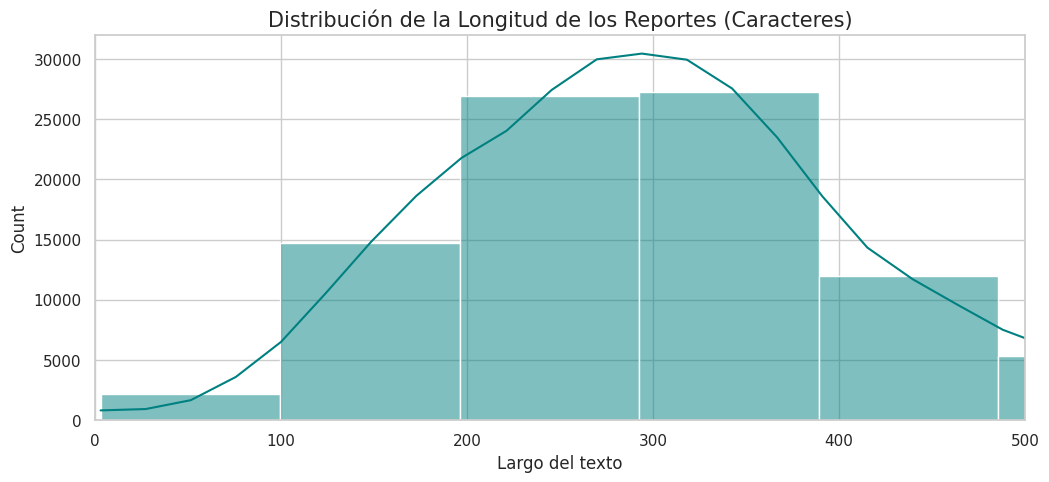

Longitud promedio del reporte: 349 caracteres.
Reporte más corto: 3 | Reporte más largo: 4829

Generando Nube de Palabras (Términos más frecuentes)...


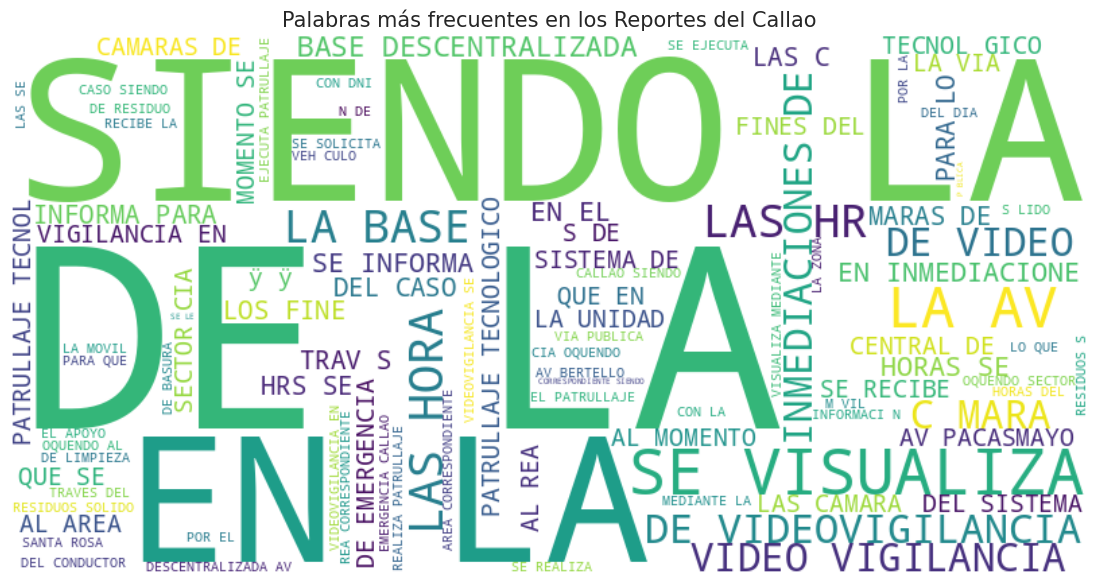

In [ ]:
# --- 2.5. ANÁLISIS EXPLORATORIO DE DATOS (EDA) ---
# Instalamos wordcloud para visualizar términos frecuentes
!pip install wordcloud -q

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilo visual
sns.set(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (12, 6)

print("--- REPORTE ESTADÍSTICO INICIAL ---")

# 1. ANÁLISIS DE LA VARIABLE OBJETIVO (Desbalanceo de Clases)
plt.figure(figsize=(12, 6))
# Contamos la frecuencia de cada tipología
ax = sns.countplot(y=y_raw, order=y_raw.value_counts().index, palette="viridis")
plt.title("Distribución de Clases (Tipología de Incidentes)", fontsize=15)
plt.xlabel("Cantidad de Reportes")
plt.ylabel("Tipo de Incidente")

# Añadir etiquetas de valor al final de las barras
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', (p.get_width() + 100, p.get_y() + 0.5))
plt.show()

print("\nOBSERVACIÓN: Note la diferencia drástica entre la clase mayoritaria y la minoritaria.")
print("Esto justifica el uso de F1-Score Macro y pesos balanceados en el modelo.\n")

# 2. ANÁLISIS DE LONGITUD DEL TEXTO
# Calculamos la longitud (número de caracteres) de cada reporte
df_sampled['largo_texto'] = df_sampled['DESCRIPCION_OCURRENCIA'].astype(str).apply(len)

plt.figure(figsize=(12, 5))
sns.histplot(data=df_sampled, x='largo_texto', bins=50, kde=True, color='teal')
plt.title("Distribución de la Longitud de los Reportes (Caracteres)", fontsize=15)
plt.xlabel("Largo del texto")
plt.xlim(0, 500) # Limitamos el eje X para ver mejor la mayoría (evitar outliers extremos)
plt.show()

print(f"Longitud promedio del reporte: {df_sampled['largo_texto'].mean():.0f} caracteres.")
print(f"Reporte más corto: {df_sampled['largo_texto'].min()} | Reporte más largo: {df_sampled['largo_texto'].max()}")

# 3. NUBE DE PALABRAS (WORDCLOUD)
# Visualizar qué palabras son las más comunes en todo el dataset
print("\nGenerando Nube de Palabras (Términos más frecuentes)...")
text_combined = " ".join(df_sampled['DESCRIPCION_OCURRENCIA'].astype(str).tolist())

wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(text_combined)

plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Palabras más frecuentes en los Reportes del Callao", fontsize=15)
plt.show()

# Limpieza de memoria temporal
del text_combined

In [ ]:
# --- 3. INGENIERÍA DE CARACTERÍSTICAS (NLP AVANZADO) ---

def preprocesamiento_gpu(textos, batch_size=2000):
    """
    Pipeline de limpieza optimizado para GPU usando SpaCy.
    Realiza: Lowercasing, Eliminación de números/ruido, Lematización y Stopwords.
    """
    textos_limpios = []
    # 1. Limpieza preliminar rápida con Regex
    # Nota: Mantenemos números si son relevantes, si no, los quitamos. Aquí los quitamos para generalizar.
    textos_pre = [re.sub(r'\d+', '', t.lower()) for t in textos]

    # 2. Tokenización y Lematización en GPU
    # Usamos nlp.pipe para procesar por lotes (mucho más rápido que apply)
    for doc in tqdm(nlp.pipe(textos_pre, batch_size=batch_size), total=len(textos), desc="Procesando NLP (GPU)"):
        # Filtros: No stopwords, no puntuación, longitud > 2
        tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and len(token.text) > 2]
        textos_limpios.append(" ".join(tokens))

    return textos_limpios

# Ejecución del Preprocesamiento
print("Iniciando limpieza de texto...")
X_limpio = preprocesamiento_gpu(X_raw.tolist())

# División Train/Test (Estratificada para mantener proporción de clases)
X_train_txt, X_test_txt, y_train, y_test = train_test_split(
    X_limpio, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Datos listos. Train: {len(X_train_txt)}, Test: {len(X_test_txt)}")

Iniciando limpieza de texto...


Procesando NLP (GPU):   0%|          | 0/98458 [00:00<?, ?it/s]

Datos listos. Train: 78766, Test: 19692


In [ ]:
# --- 4. MOTOR DE OPTIMIZACIÓN EVOLUTIVA (PyGAD + PyTorch) ---

# A. Modelo Espejo en PyTorch (Para entrenamiento ultra-rápido en GA)
class LogisticRegressionGPU(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegressionGPU, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

# B. Función de Fitness (Evaluación de Genomas)
def fitness_func(ga_instance, solution, sol_idx):
    # Decodificación del Genoma (Hiperparámetros)
    C_val = solution[0]
    max_feat = int(solution[1])
    ngram_max = int(solution[2])
    min_df = solution[3]
    max_df = solution[4]

    # Guardas de seguridad para parámetros inválidos
    if min_df >= max_df: return 0.0

    # 1. Vectorización Dinámica (TF-IDF)
    try:
        vectorizer = TfidfVectorizer(
            max_features=max_feat,
            ngram_range=(1, ngram_max),
            min_df=min_df,
            max_df=max_df,
            dtype=np.float32
        )
        # Ajustamos solo con una submuestra para velocidad durante el GA
        # (Usamos los primeros 10k registros para que el GA sea rápido)
        limit = 10000
        X_vec_subset = vectorizer.fit_transform(X_train_txt[:limit])
        y_train_subset = y_train[:limit]
    except ValueError:
        return 0.0

    # 2. Validación Cruzada Rápida en GPU
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    f1_scores = []

    # Convertimos a tensores una sola vez si es posible, pero aquí lo hacemos por fold
    # para no saturar memoria si el vocabulario es grande
    for train_idx, val_idx in skf.split(X_vec_subset, y_train_subset):
        # Preparar Tensores
        X_tr_t = torch.tensor(X_vec_subset[train_idx].toarray(), device=device)
        y_tr_t = torch.tensor(y_train_subset[train_idx], dtype=torch.long, device=device)
        X_val_t = torch.tensor(X_vec_subset[val_idx].toarray(), device=device)

        # Iniciar Modelo
        model = LogisticRegressionGPU(X_tr_t.shape[1], len(clases)).to(device)

        # Optimizador y Loss (Con pesos de clase para corregir desbalanceo)
        optimizer = optim.Adam(model.parameters(), lr=0.1, weight_decay=1.0/C_val if C_val > 0 else 0)
        criterion = nn.CrossEntropyLoss(weight=class_weights_tensor) # <--- CLAVE PARA MEJORA

        # Training Loop (Breve para el GA)
        model.train()
        for _ in range(60): # Épocas reducidas para velocidad
            optimizer.zero_grad()
            output = model(X_tr_t)
            loss = criterion(output, y_tr_t)
            loss.backward()
            optimizer.step()

        # Evaluación
        model.eval()
        with torch.no_grad():
            preds = torch.argmax(model(X_val_t), dim=1).cpu().numpy()
            f1_scores.append(f1_score(y_train_subset[val_idx], preds, average='macro'))

        # Limpieza VRAM
        del X_tr_t, y_tr_t, X_val_t, model
        torch.cuda.empty_cache()

    return np.mean(f1_scores)

# C. Configuración del Espacio de Búsqueda
gene_space = [
    {'low': 0.1, 'high': 10.0},       # C (Regularización)
    {'low': 3000, 'high': 8000, 'step': 100}, # Max Features
    {'low': 1, 'high': 2, 'step': 1},         # N-Grams
    {'low': 0.001, 'high': 0.05},     # Min DF
    {'low': 0.7, 'high': 0.99}        # Max DF
]

print("✅ Motor Evolutivo configurado.")

✅ Motor Evolutivo configurado.


In [ ]:
# --- 5. EJECUCIÓN DE LA BÚSQUEDA EVOLUTIVA ---

ga_instance = pygad.GA(
    num_generations=15,       # Generaciones
    num_parents_mating=4,     # Padres
    fitness_func=fitness_func,
    sol_per_pop=8,            # Población
    num_genes=len(gene_space),
    gene_space=gene_space,
    parent_selection_type="tournament",
    keep_parents=2,
    mutation_type="random",
    mutation_percent_genes=20,
    save_best_solutions=True
)

print(f"🧬 Iniciando evolución de hiperparámetros en {device}...")
# Barra de progreso manual vinculada al GA
with tqdm(total=ga_instance.num_generations, desc="Evolucionando") as pbar:
    ga_instance.on_generation = lambda ga: pbar.update(1)
    ga_instance.run()

# Extracción del Mejor Cromosoma
solution, solution_fitness, _ = ga_instance.best_solution()
best_C = solution[0]
best_max_feat = int(solution[1])
best_ngram = int(solution[2])
best_min_df = solution[3]
best_max_df = solution[4]

print(f"\n🏆 Mejor Fitness (F1-Macro estimado): {solution_fitness:.4f}")
print(f"🧬 Genoma Ganador:\n - C: {best_C:.4f}\n - Vocabulario: {best_max_feat}\n - N-Grams: (1, {best_ngram})\n - DF: {best_min_df:.3f} - {best_max_df:.3f}")

🧬 Iniciando evolución de hiperparámetros en cuda...


/usr/local/lib/python3.12/dist-packages/pygad/pygad.py:1149: UserWarning: Use the 'save_best_solutions' parameter with caution as it may cause memory overflow when either the number of generations or number of genes is large.
  warnings.warn("Use the 'save_best_solutions' parameter with caution as it may cause memory overflow when either the number of generations or number of genes is large.")


Evolucionando:   0%|          | 0/15 [00:00<?, ?it/s]


🏆 Mejor Fitness (F1-Macro estimado): 0.3425
🧬 Genoma Ganador:
 - C: 9.7290
 - Vocabulario: 4700
 - N-Grams: (1, 1)
 - DF: 0.009 - 0.844


--- Entrenando Modelo Final con Hiperparámetros Evolucionados ---


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



REPORTE DE CLASIFICACIÓN FINAL (EVO-OPTIMIZED)
                                precision    recall  f1-score   support

                  AMBIENTALES        0.91      0.86      0.89      5678
           APOYO AL CIUDADANO        0.68      0.59      0.63      4240
FISCALIZACION Y DEFENSA CIVIL        0.78      0.78      0.78      3418
                       FISICA        0.03      0.18      0.05        22
                FISICA(SALUD)        0.23      0.76      0.36       221
          PROTECCION FAMILIAR        0.10      0.62      0.17        86
                    SEGURIDAD        0.73      0.68      0.70      2649
    TRANSITO Y SEGURIDAD VIAL        0.88      0.88      0.88      3378

                      accuracy                           0.76     19692
                     macro avg       0.54      0.67      0.56     19692
                  weighted avg       0.80      0.76      0.78     19692



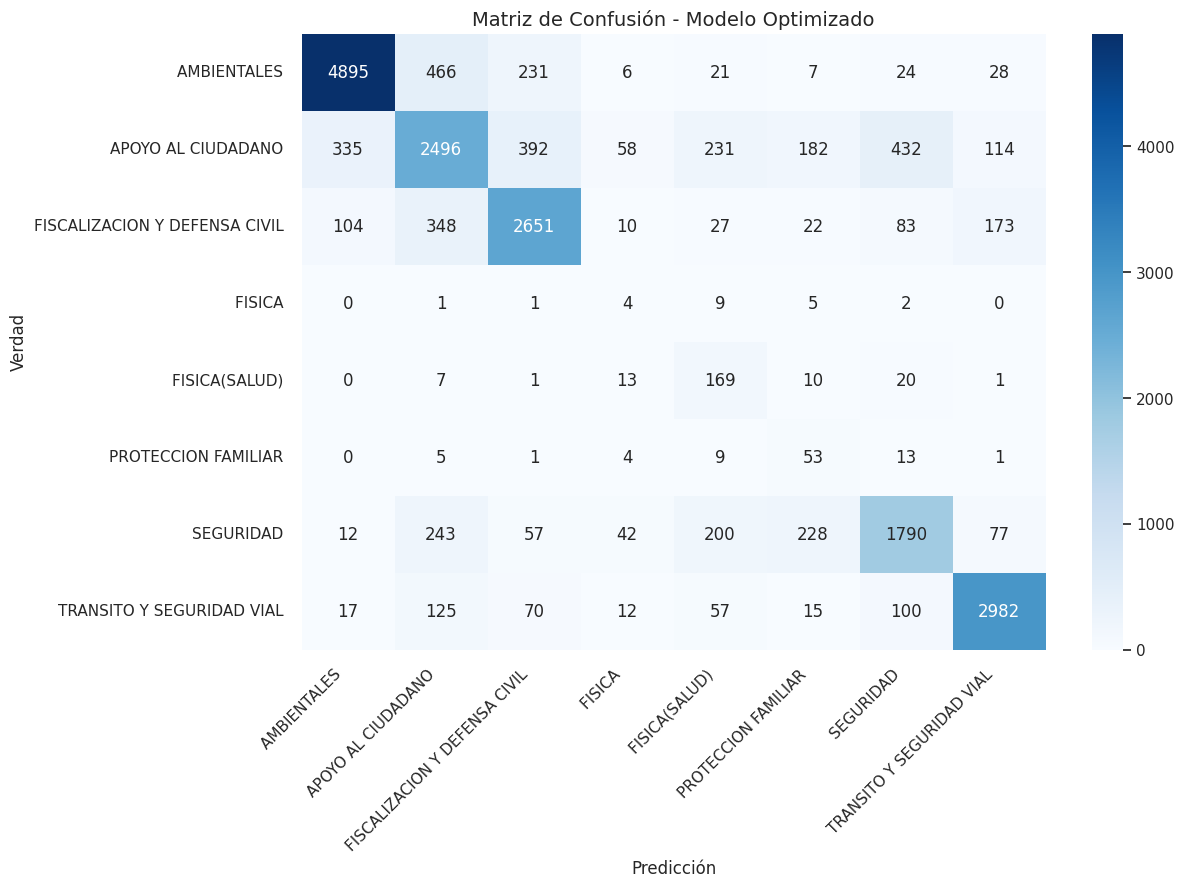

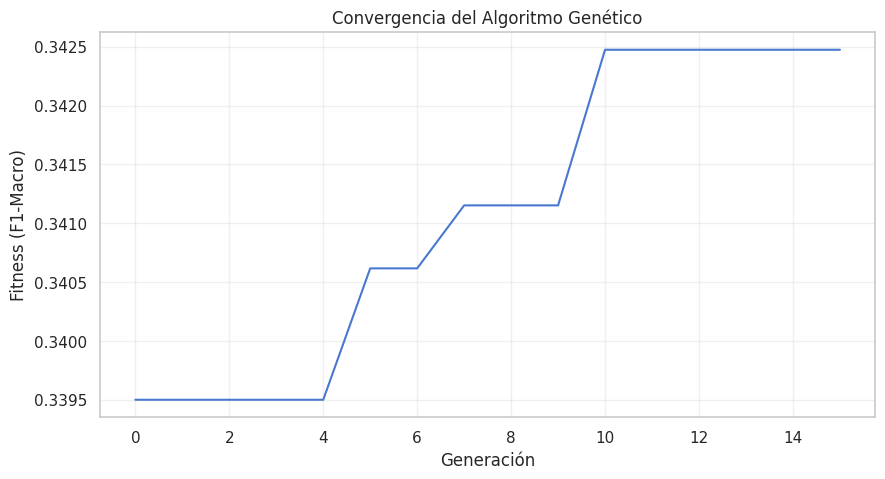

In [ ]:
# --- 6. ENTRENAMIENTO FINAL Y VALIDACIÓN ---

print("--- Entrenando Modelo Final con Hiperparámetros Evolucionados ---")

# 1. Vectorización Definitiva (Con todo el train set)
tfidf_final = TfidfVectorizer(
    max_features=best_max_feat,
    ngram_range=(1, best_ngram),
    min_df=best_min_df,
    max_df=best_max_df
)
X_train_final = tfidf_final.fit_transform(X_train_txt)
X_test_final = tfidf_final.transform(X_test_txt)

# 2. Modelo de Sklearn (L-BFGS es más preciso para convergencia final)
model_final = LogisticRegression(
    C=best_C,
    solver='lbfgs',
    multi_class='multinomial',
    max_iter=1000,
    class_weight='balanced',
    n_jobs=-1
)

model_final.fit(X_train_final, y_train)

# 3. Predicciones
y_pred = model_final.predict(X_test_final)

# 4. Reporte de Resultados
print("\n" + "="*60)
print("REPORTE DE CLASIFICACIÓN FINAL (EVO-OPTIMIZED)")
print("="*60)
print(classification_report(y_test, y_pred, target_names=clases))

# 5. Matriz de Confusión Visual
plt.figure(figsize=(12, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=clases, yticklabels=clases)
plt.title('Matriz de Confusión - Modelo Optimizado', fontsize=14)
plt.ylabel('Verdad', fontsize=12)
plt.xlabel('Predicción', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()

# 6. Gráfico de Convergencia del GA
plt.figure(figsize=(10, 5))
plt.plot(ga_instance.best_solutions_fitness)
plt.title("Convergencia del Algoritmo Genético")
plt.xlabel("Generación")
plt.ylabel("Fitness (F1-Macro)")
plt.grid(True, alpha=0.3)
plt.show()